# Looking at the historical US market returns

## Imports

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## Data

### Shiller's historical S&P 500 data

In [102]:
df = pd.read_excel('../data/shiller_sp500.xls', sheet_name='Data', header=None, skiprows=8)

#### Manually adjust columns names

There's some weird formatting due to a preamble above the first several columns and some unused columns.  I chose slightly shorter names here for convenience and drop the columns with no actual data.

In [103]:
dropped_columns = ["No Data 1", "No Data 2"]

columns = [
    "Date",
    "S&P",
    "Dividend",
    "Earnings",
    "CPI",
    "Date Fraction",
    "Long Interest Rate",
    "Real Price",
    "Real Dividend",
    "Real Total Return Price",
    "Real Earnings",
    "Real TR Scaled Earnings",
    "CAPE",
    dropped_columns[0],
    "TR CAPE",
    dropped_columns[1],
    "Excess CAPE Yield",
    "Monthly Bond Returns",
    "Monthly Real Bond Returns",
    "10 Year Real Stock Return",
    "10 Year Real Bond Return",
    "10 Year Excess Return"
]

df.columns = columns

# Sanity check
filled_dropped_rows = df[~df[dropped_columns[0]].isna() | ~df[dropped_columns[1]].isna()]
print("Was there any data in the dropped columns?", len(filled_dropped_rows) > 0)

# Drop the empty columns
df = df.drop(columns=dropped_columns)

Was there any data in the dropped columns? False


#### Drop trailing row that contains text instead of numeric entries

The last row for some entries describes the extrapolation methodology.  These will confuse plots/analyses, so they're dropped.

In [104]:
last_index = len(df) - 1
df = df.drop(last_index)

## Analysis

### Dividend re-invested Compound Annual Growth Rate (CAGR)

## Tests/scratch

### Test plotting

552


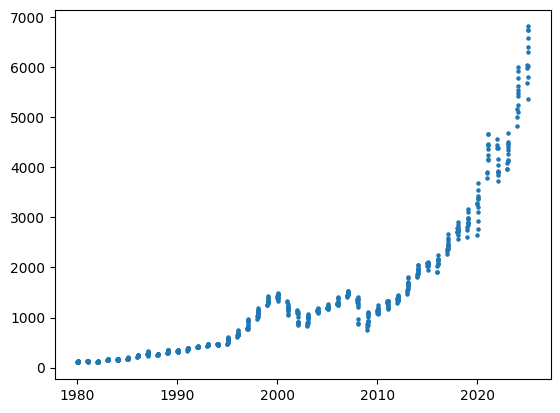

In [105]:
data = df[(df["Date"] > 1980)]
print(len(data))
plt.scatter(x=data["Date"], y=data["S&P"], s=5)

### Looking at historical returns

In [106]:
initial_date = 2014.01
final_date = 2025.01
period = final_date - initial_date

df[(df["Date"] == initial_date) | (df["Date"] == final_date)]

,Date,S&P,Dividend,Earnings,CPI,Date Fraction,Long Interest Rate,Real Price,Real Dividend,Real Total Return Price,Real Earnings,Real TR Scaled Earnings,CAPE,TR CAPE,Excess CAPE Yield,Monthly Bond Returns,Monthly Real Bond Returns,10 Year Real Stock Return,10 Year Real Bond Return,10 Year Excess Return
1716,2014.01,1822.36,35.403333,100.416667,233.916,2014.041667,2.86,2535.220962,49.252218,1.398295e+06,139.697117,77049.602028,24.859609,27.474103,0.035253,1.015414,46.482176,0.0917,-0.0153,0.106999
1848,2025.01,5979.5155,75.269937,212.343333,317.671,2025.041667,4.63,6125.337141,77.105535,4.107119e+06,217.521722,145851.170515,37.129220,39.899969,0.011804,1.018269,38.504542,NaN,NaN,NaN


In [107]:
rows = df.copy()
rows["Dividend Diff"] = rows["Dividend"].diff()
losing_rows = rows[(rows["Dividend Diff"] < 0) & (rows["Date"] > 2000)]
losing_rows

,Date,S&P,Dividend,Earnings,CPI,Date Fraction,Long Interest Rate,Real Price,Real Dividend,Real Total Return Price,...,Real TR Scaled Earnings,CAPE,TR CAPE,Excess CAPE Yield,Monthly Bond Returns,Monthly Real Bond Returns,10 Year Real Stock Return,10 Year Real Bond Return,10 Year Excess Return,Dividend Diff
1551,2000.04,1461.36,16.740000,51.273333,171.3,2000.291667,5.99,2776.140388,31.800918,1.184179e+06,...,41548.141516,43.528574,47.155407,-0.008080,0.972074,29.471725,-0.025533,0.036085,-0.061617,-2.000000e-02
1552,2000.05,1418.48,16.720000,51.596667,171.5,2000.375000,6.44,2691.538919,31.725883,1.149219e+06,...,41802.409948,41.966051,45.413038,-0.011844,1.030618,28.615297,-0.028591,0.043080,-0.071671,-2.000000e-02
1553,2000.06,1461.96,16.700000,51.920000,172.4,2000.458333,6.1,2759.559741,31.522509,1.179384e+06,...,41884.606283,42.781972,46.245587,-0.008916,1.008805,29.337488,-0.034499,0.042803,-0.077302,-2.000000e-02
1554,2000.07,1473,16.583333,52.513333,172.8,2000.541667,6.05,2773.962465,31.229833,1.186652e+06,...,42304.846183,42.758094,46.170728,-0.008560,1.021580,29.527300,-0.035265,0.044066,-0.079331,-1.166667e-01
1555,2000.08,1485.46,16.466667,53.106667,172.8,2000.625000,5.83,2797.427212,31.010126,1.197795e+06,...,42822.358169,42.869565,46.242114,-0.007362,1.007117,30.164509,-0.035469,0.044724,-0.080193,-1.166667e-01
1556,2000.09,1468.05,16.350000,53.700000,173.7,2000.708333,5.8,2750.316033,30.630883,1.178716e+06,...,43116.413134,41.898008,45.147502,-0.006843,1.009362,30.221774,-0.030767,0.045153,-0.075919,-1.166667e-01
1557,2000.10,1390.14,16.323333,52.466667,174,2000.791667,5.74,2599.865394,30.528198,1.115327e+06,...,42094.672963,39.369699,42.382640,-0.005150,1.006294,30.452122,-0.021143,0.045459,-0.066603,-2.666667e-02
1558,2000.11,1378.04,16.296667,51.233333,174.1,2000.875000,5.72,2575.755432,30.460819,1.106073e+06,...,41122.029660,38.782142,41.713360,-0.004737,1.041828,30.626197,-0.017954,0.043035,-0.060989,-2.666667e-02
1559,2000.12,1330.93,16.270000,50.000000,174,2000.958333,5.24,2489.129763,30.428453,1.069963e+06,...,40196.075367,37.274238,40.059879,0.001047,1.010566,31.925572,-0.011259,0.034032,-0.045291,-2.666667e-02
1560,2001.01,1335.63,16.170000,48.480000,175.1,2001.041667,5.16,2482.227546,30.051451,1.068073e+06,...,38768.347904,36.978868,39.712810,0.002096,1.008962,32.060223,-0.008182,0.032519,-0.040701,-1.000000e-01


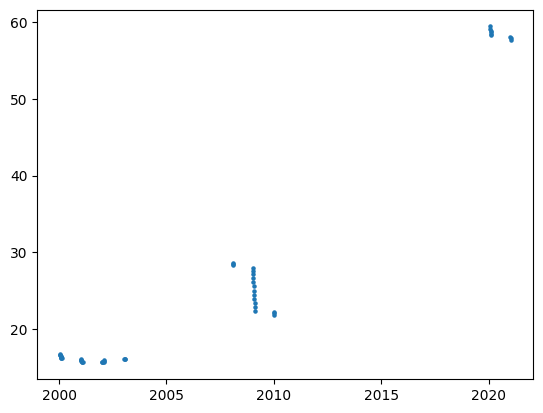

In [108]:
plt.scatter(x=losing_rows["Date"], y=losing_rows["Dividend"], s=5)

In [109]:
initial = df[df["Date"] == initial_date]["S&P"].iloc[0]
final = df[df["Date"] == final_date]["S&P"].iloc[0]

final = 1 * final

rate = math.pow(final / initial, 1 / period) - 1
print(rate)

0.11406872818940905
